In [ ]:
# imports for MLP Model
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [56]:
# importing dataset
df = pd.read_csv('Airline_Delay_Cause.csv')

# Removing rows where arr_delay, arr_flights or arr_del15 are missing
df = df.dropna(subset=["arr_delay", "arr_flights", "arr_del15"]).reset_index(drop=True)

# Removing rows where arr_flights is 0, preventing division by zero
df = df[df["arr_flights"] > 0].reset_index(drop=True)
df["delay_rate"] = df["arr_del15"] / df["arr_flights"]

print("Dataset shape after cleaning:", df.shape)

# Identifying the categorical columns 
cat_cols = df.select_dtypes(include=["object", "category"]).columns
print("\nCategorical columns:", list(cat_cols))

# One-hot encoding the categorical columns into numeric values
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
print(f"Encoded dataset shape: {df_encoded.shape}")

Dataset shape after cleaning: (171223, 21)

Categorical columns: ['carrier', 'carrier_name', 'airport']
Encoded dataset shape: (171223, 450)


In [57]:
# setting threshold value: if 25% of flights are delayed longer than 15min then we have an issue... high delay
delay_rate_threshold = 0.25

# encoding our target variable into numeric values: High Delay = 1 and Low Delay = 0 
df_encoded["High_Delay"] = (df_encoded["delay_rate"] > delay_rate_threshold).astype(int)

X_cls = df_encoded.drop("High_Delay", axis=1) # dropping target variable from features
y_cls = df_encoded["High_Delay"] # creating separate variable to hold target values

# Checking to see how many data points actually have high vs low delay
print(f"\nTarget distribution:")
print(y_cls.value_counts())

# Splitting the data: 70% training, 20% Validation, 10% Test 
X_train_cls, X_temp_cls, y_train_cls, y_temp_cls = train_test_split(
    X_cls, y_cls, test_size=0.3, random_state=42, stratify=y_cls
)

X_val_cls, X_test_cls, y_val_cls, y_test_cls = train_test_split(
    X_temp_cls, y_temp_cls, test_size=(1/3), random_state=42, stratify=y_temp_cls
)

# Standardizing the data
scaler_cls = StandardScaler()
X_train_cls_scaled = scaler_cls.fit_transform(X_train_cls)
X_val_cls_scaled = scaler_cls.transform(X_val_cls)
X_test_cls_scaled = scaler_cls.transform(X_test_cls)



Target distribution:
High_Delay
0    133358
1     37865
Name: count, dtype: int64


In [58]:
# class that was supposed to print out progress during training progress, but now plays an important part of being able to print out the graphs at the end
class PrintProgressMLP(MLPClassifier):
    def _fit(self, X, y, incremental=False):
        super_result = super()._fit(X, y, incremental)
        if self.n_iter_ % 10 == 0 or self.n_iter_ == 1:
            print(f"Epoch {self.n_iter_} — Loss: {self.loss_:.4f}")
        return super_result 

# creating an instance of the multilayer perceptron classifier 
mlp_cls = PrintProgressMLP(
    hidden_layer_sizes=(128, 64, 32), # 3 hidden layers, hence the multilayer
    activation='relu', 
    solver='adam', 
    learning_rate='adaptive', 
    learning_rate_init=0.001, 
    batch_size=256,
    max_iter=200,
    random_state=42,
    early_stopping=True,
    n_iter_no_change=10,
    verbose=False
)


In [59]:
print("\nTraining MLP Classifier...") # just so you know stuff is working

start_mlp_cls = time.time() # getting a start time

# training the model
mlp_cls.fit(X_train_cls_scaled, y_train_cls) 

end_mlp_cls = time.time() # getting an end time
time_mlp_cls = end_mlp_cls - start_mlp_cls # calculating total training time

print(f"Training completed in {time_mlp_cls:.2f} seconds") # printing total training time

# Predictions
y_val_pred_mlp = mlp_cls.predict(X_val_cls_scaled) # validation
y_test_pred_mlp = mlp_cls.predict(X_test_cls_scaled) # test

# Evaluating the performance 
# Validation set metrics
acc_val_mlp = accuracy_score(y_val_cls, y_val_pred_mlp)
f1_val_mlp = f1_score(y_val_cls, y_val_pred_mlp)
rec_val_mlp = recall_score(y_val_cls, y_val_pred_mlp)
prec_val_mlp = precision_score(y_val_cls, y_val_pred_mlp)
# Test set metrics
acc_test_mlp = accuracy_score(y_test_cls, y_test_pred_mlp)
f1_test_mlp = f1_score(y_test_cls, y_test_pred_mlp)
rec_test_mlp = recall_score(y_test_cls, y_test_pred_mlp)
prec_test_mlp = precision_score(y_test_cls, y_test_pred_mlp)

# Printing the results
print("\n" + "="*60)
print("MLP CLASSIFIER PERFORMANCE")
print("="*60)

print("\nMLP Classifier (Validation):")
print("Accuracy: %.4f" % acc_val_mlp)
print("F1-score: %.4f" % f1_val_mlp)

print("\nMLP Classifier (Test):")
print("Accuracy: %.4f" % acc_test_mlp)
print("F1-score: %.4f" % f1_test_mlp)
print("Recall: %.4f" % rec_test_mlp)
print("Precision: %.4f" % prec_test_mlp)


Training MLP Classifier...
Training completed in 167.80 seconds

MLP CLASSIFIER PERFORMANCE

MLP Classifier (Validation):
Accuracy: 0.9875
F1-score: 0.9719

MLP Classifier (Test):
Accuracy: 0.9874
F1-score: 0.9717
Recall: 0.9786
Precision: 0.9649


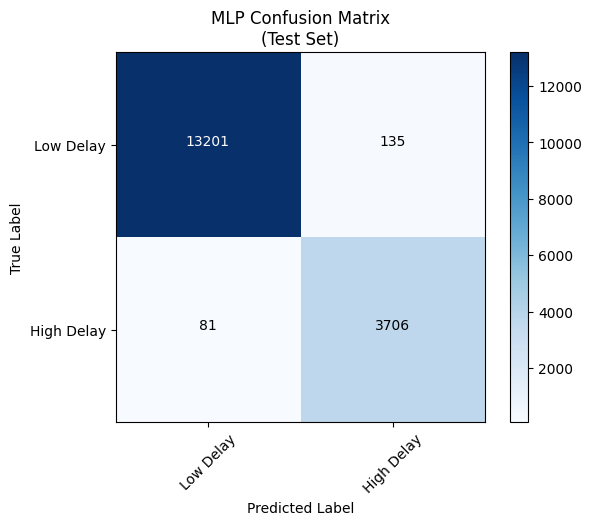

In [60]:
# Plotting Confusion Matrix
plt.figure()
cm = confusion_matrix(y_test_cls, y_test_pred_mlp)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('MLP Confusion Matrix\n(Test Set)')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Low Delay', 'High Delay'], rotation=45)
plt.yticks(tick_marks, ['Low Delay', 'High Delay'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")


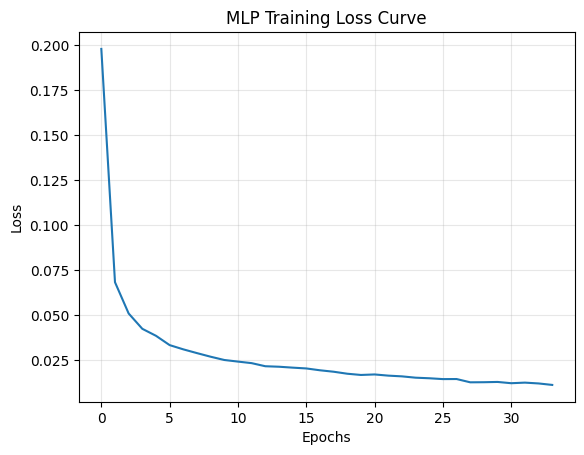

In [61]:
# Plotting training loss
plt.figure()
if hasattr(mlp_cls, 'loss_curve_'):
    plt.plot(mlp_cls.loss_curve_)
    plt.title('MLP Training Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Loss curve not available', 
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes)
    plt.title('MLP Training Loss Curve')

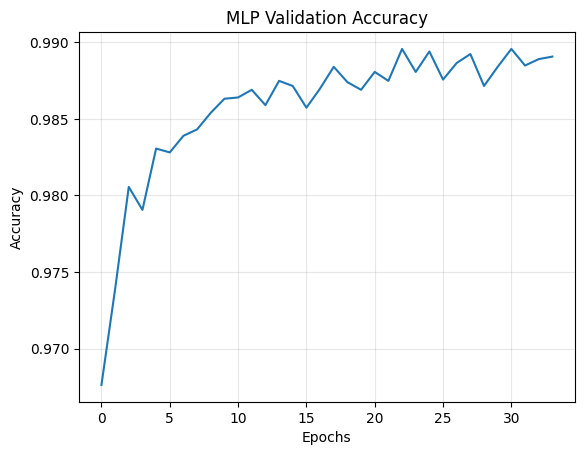

In [62]:
plt.figure()
if hasattr(mlp_cls, 'validation_scores_'):
    plt.plot(mlp_cls.validation_scores_)
    plt.title('MLP Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
else:
    # Create a simple bar chart of performance metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [acc_test_mlp, prec_test_mlp, rec_test_mlp, f1_test_mlp]
    bars = plt.bar(metrics, values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
    plt.title('MLP Test Performance Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')